In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt


In [45]:
class Sinkhorn(nn.Module):
    def __init__(self, encoder, num_protos, proto_dim, temp, proto_coef,
            device='cpu', obs_transform=None, num_iters=3):
        super(Sinkhorn, self).__init__()
        self.encoder = encoder
        self.protos = torch.nn.Linear(proto_dim, num_protos, bias=False)
        self.temp = temp
        self.proto_coef = proto_coef
        self.num_iters = num_iters

    def code_loss(self, z1, z2):
        scores1 = self.protos(z1)
        log_p_s = F.log_softmax(scores1 / self.temp, dim=1)
        
        with torch.no_grad():
            scores2 = self.protos(z2)
            q = self.sinkhorn(scores2)
        
        return -(q * log_p_s).sum(dim=1).mean()
        
    def forward(self, x1, x2):
        z1 = self.encoder(x1)
        z2 = self.encoder(x2)
        
        C = self.protos.weight.data.clone()
        C = F.normalize(C, dim=1, p=2)
        self.protos.weight.data.copy_(C)
        
        z1 = F.normalize(z1, dim=1, p=2)
        z2 = F.normalize(z2, dim=1, p=2)
        
        loss1 = self.code_loss(z1, z2)
        loss2 = self.code_loss(z2, z1)
        
        info = dict(z1=z1, z2=z2)
        
        return loss1 + loss2, info

    def sinkhorn(self, scores):
        def remove_infs(x):
            m = x[torch.isfinite(x)].max().item()
            x[torch.isinf(x)] = m
            return x

        Q = scores / self.temp
        Q -= Q.max()

        Q = torch.exp(Q).T
        Q = remove_infs(Q)
        Q /= Q.sum()

        r = torch.ones(Q.shape[0], device=Q.device) / Q.shape[0]
        c = torch.ones(Q.shape[1], device=Q.device) / Q.shape[1]
        for it in range(self.num_iters):
            u = Q.sum(dim=1)
            u = remove_infs(r / u)
            Q *= u.unsqueeze(dim=1)
            Q *= (c / Q.sum(dim=0)).unsqueeze(dim=0)
        Q = Q / Q.sum(dim=0, keepdim=True)
        return Q.T

In [28]:
def gen_data(n):
    means = [[1, 1.], [1, -1.], [-1, 1.], [-1, -1.]]
    std = [0.25]
    Xs = []
    Ys = np.zeros((n, 4))
    for i, mean in enumerate(means):
        data = np.random.normal(mean, std, size=(n // 4, 2))
        Xs.append(data)
        start = i * (n // 4)scores1
        end = (i + 1) * (n // 4)
        Ys[start:end, i] = 1 
        
    return np.concatenate(Xs), Ys

def get_batch(Xs, Ys, batch_size, n):
    # sample two points from a random cluster
    clusts = np.random.randint(4, size=batch_size)
    NUM_PER_CLASS = n // 4
    start_idx = clusts * NUM_PER_CLASS
    
    rand_idx1 = np.random.randint(NUM_PER_CLASS, size=batch_size) + start_idx
    rand_idx2 = np.random.randint(NUM_PER_CLASS, size=batch_size) + start_idx
    
    x1 = Xs[rand_idx1]
    x2 = Xs[rand_idx2]
    
    return x1, x2, clusts
    


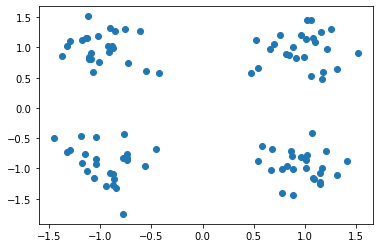

In [29]:
n = 100
Xs, Ys = gen_data(n)
plt.scatter(Xs[:, 0], Xs[:, 1])
plt.show()

In [33]:
x1, x2, clusts = get_batch(Xs, Ys, 4, n)

In [71]:
iterations = 100
batch_size = 32

num_protos = 4
proto_dim = 16
temp = 0.01
proto_coef = 0.5

encoder = nn.Sequential(nn.Linear(2, 256), nn.ReLU(), nn.Linear(256, proto_dim))

model = Sinkhorn(encoder, num_protos, proto_dim, temp, proto_coef)

optim = torch.optim.Adam(model.parameters(), lr=1e-3)

for i in range(iterations):
    x1, x2, clusts = get_batch(Xs, Ys, batch_size, n)
    
    x1 = torch.from_numpy(x1).float()
    x2 = torch.from_numpy(x2).float()
    optim.zero_grad()
    loss, info = model(x1, x2)
    loss.backward()
    optim.step()
    
    scores1 = model.protos(info['z1'])
    probs = F.log_softmax(scores1 / model.temp, dim=1).exp()
    entropy = -(probs * torch.log(probs)).sum(dim=1).mean()
    print(probs.detach().numpy())
    print(loss.item(), entropy.item())
    

[[7.7093184e-01 7.3351106e-29 2.2906810e-01 1.1552611e-09]
 [5.7492268e-15 2.5140316e-20 1.0000000e+00 3.5700023e-18]
 [1.5120353e-01 2.7591224e-28 8.4879649e-01 1.5751562e-09]
 [7.6764834e-01 2.4254255e-27 2.3235160e-01 7.5254902e-10]
 [5.2565583e-09 9.2730944e-12 1.0000000e+00 1.8217059e-15]
 [1.4346754e-12 6.4822101e-13 1.0000000e+00 1.9756853e-16]
 [6.7332688e-11 7.8541257e-15 1.0000000e+00 8.6726492e-17]
 [4.8150832e-06 9.9999523e-01 9.2412034e-09 1.2085377e-15]
 [7.5395205e-06 6.9770201e-10 9.9848551e-01 1.5070575e-03]
 [1.7683806e-01 1.1754647e-29 8.2316196e-01 1.1992829e-09]
 [1.4210342e-04 9.9985790e-01 2.4668625e-10 1.2509279e-13]
 [2.1461343e-02 3.5501293e-28 9.7853869e-01 5.0399207e-10]
 [6.1935347e-14 2.4988496e-19 1.0000000e+00 8.3865659e-18]
 [3.2975439e-02 1.1218299e-27 9.6702451e-01 7.6439849e-10]
 [2.0972570e-09 1.0000000e+00 1.5746956e-14 1.7596508e-18]
 [1.7066986e-08 1.0000000e+00 1.0696810e-14 9.9416811e-18]
 [1.3546027e-02 2.5034345e-30 9.8645395e-01 1.9995522e-1

[[1.00000000e+00 8.09001510e-28 5.86124577e-26 3.82393146e-13]
 [9.99999523e-01 3.66350254e-23 1.66932207e-21 4.35524328e-07]
 [1.76598757e-23 9.88988578e-01 1.10114031e-02 4.47381458e-15]
 [1.00000000e+00 6.17372010e-29 2.24769159e-27 1.13583654e-14]
 [1.00000000e+00 3.06787266e-20 3.36552461e-17 2.39730215e-11]
 [2.96917769e-27 7.13861438e-23 9.12379492e-19 1.00000000e+00]
 [1.24883383e-22 9.98274922e-01 1.72509521e-03 3.03150449e-10]
 [1.00000000e+00 3.06787266e-20 3.36552461e-17 2.39730215e-11]
 [1.14745654e-20 1.06526306e-04 9.99893427e-01 2.46604812e-18]
 [9.99959707e-01 1.52374147e-16 1.99356827e-15 4.02467049e-05]
 [2.99092081e-22 9.44346102e-05 9.99905586e-01 2.77773247e-19]
 [2.01570894e-20 3.95763600e-05 9.99960423e-01 5.05163171e-18]
 [1.48599922e-23 9.98576045e-01 1.42395985e-03 1.29969302e-09]
 [1.00000000e+00 1.27458005e-26 3.78719499e-25 6.54781085e-16]
 [1.00000000e+00 2.19327155e-27 1.57726292e-25 3.75953262e-12]
 [5.80706261e-23 9.87374902e-01 1.26250219e-02 2.620916

In [82]:
vals, idxs = probs.max(dim=1)
print(idxs)
print(clusts)

tensor([0, 1, 3, 0, 0, 1, 3, 1, 1, 3, 0, 1, 0, 3, 1, 1, 0, 1, 1, 0, 3, 0, 3, 0,
        0, 0, 2, 3, 1, 3, 0, 0])
[0 3 2 0 0 3 2 3 3 2 0 3 0 2 3 3 0 3 3 0 2 0 2 0 0 0 1 2 3 2 0 0]


In [84]:
clust_to_idx_counts = {0: [0,0,0,0], 1: [0,0,0,0], 2: [0,0,0,0], 3: [0,0,0,0]}
for idx, y in zip(idxs, clusts):
    clust_to_idx_counts[y][idx] += 1


In [85]:
clust_to_idx_counts

{0: [13, 0, 0, 0], 1: [0, 0, 1, 0], 2: [0, 0, 0, 8], 3: [0, 10, 0, 0]}